In [406]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import datetime as dt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [284]:
df = pd.read_csv('/Users/data/VsCodeProjects/DataScience/data/raw/eurusd_hour.csv')
df.head(5)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93084 entries, 0 to 93083
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    93084 non-null  object 
 1   Time    93084 non-null  object 
 2   BO      93084 non-null  float64
 3   BH      93084 non-null  float64
 4   BL      93084 non-null  float64
 5   BC      93084 non-null  float64
 6   BCh     93084 non-null  float64
 7   AO      93084 non-null  float64
 8   AH      93084 non-null  float64
 9   AL      93084 non-null  float64
 10  AC      93084 non-null  float64
 11  ACh     93084 non-null  float64
dtypes: float64(10), object(2)
memory usage: 8.5+ MB


In [4]:
from datetime import datetime, date, time

#перевод с строки даты в дату общего формата
def str_to_datetime(s: str):
    splited = s.split('-')
    year, month, day = int(splited[0]), int(splited[1]), int(splited[2])
    return datetime.datetime(year=year, month=month, day=day)




Изменение формата времени к объекту datetime

In [5]:
def str_hours_to_datetime(t: str):
    splited = t.split(':')
    hour, minute = int(splited[0]), int(splited[1])
    return datetime.time(hour=hour, minute=minute)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93084 entries, 0 to 93083
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    93084 non-null  object 
 1   Time    93084 non-null  object 
 2   BO      93084 non-null  float64
 3   BH      93084 non-null  float64
 4   BL      93084 non-null  float64
 5   BC      93084 non-null  float64
 6   BCh     93084 non-null  float64
 7   AO      93084 non-null  float64
 8   AH      93084 non-null  float64
 9   AL      93084 non-null  float64
 10  AC      93084 non-null  float64
 11  ACh     93084 non-null  float64
dtypes: float64(10), object(2)
memory usage: 8.5+ MB


In [285]:
df['Date'] = pd.to_datetime(df['Date']).dt.date
df['Time'] = pd.to_datetime(df['Time']).dt.time

/var/folders/9c/vk6dn3k90g9cy2bswv5c6kk00000gn/T/ipykernel_61727/4204116191.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time']).dt.time


In [286]:
df['Datetime'] = df.apply(lambda row: datetime.combine(date=row['Date'], time=row['Time']), axis=1)

In [287]:
df.BO.describe()

count    93084.000000
mean         1.265734
std          0.126894
min          1.035530
25%          1.139878
50%          1.274100
75%          1.357615
max          1.601310
Name: BO, dtype: float64

In [87]:
df.BC.describe()

count    93084.000000
mean         1.265733
std          0.126892
min          1.035550
25%          1.139880
50%          1.274105
75%          1.357630
max          1.601390
Name: BC, dtype: float64

In [88]:
import matplotlib.pyplot as plt

<Axes: >

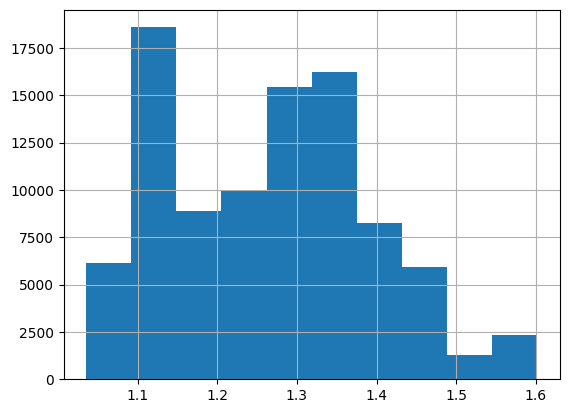

In [89]:
df.BC.hist()

<Axes: >

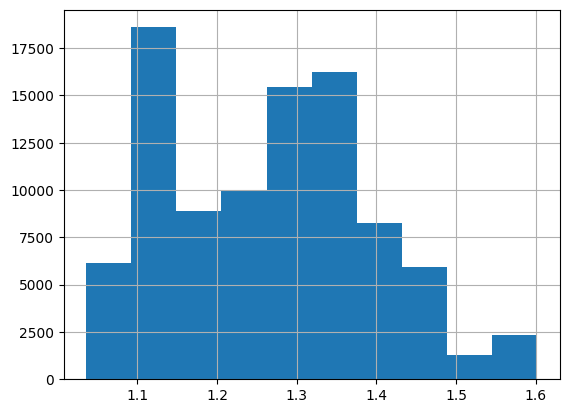

In [90]:
df.AC.hist()

In [288]:
df['Datetime']

0       2005-05-02 00:00:00
1       2005-05-02 01:00:00
2       2005-05-02 02:00:00
3       2005-05-02 03:00:00
4       2005-05-02 04:00:00
                ...        
93079   2020-04-29 18:00:00
93080   2020-04-29 19:00:00
93081   2020-04-29 20:00:00
93082   2020-04-29 21:00:00
93083   2020-04-29 22:00:00
Name: Datetime, Length: 93084, dtype: datetime64[ns]

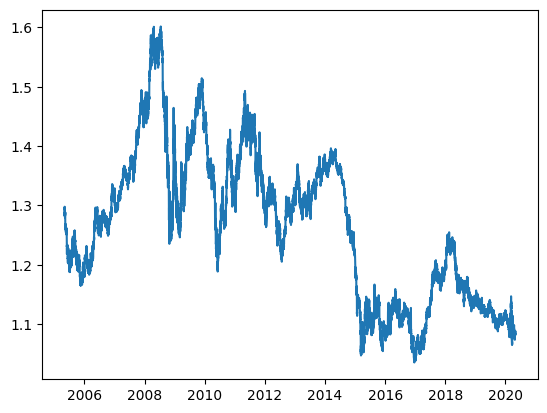

In [113]:
plt.plot(df['Datetime'], df['BC'])


In [289]:
df.index = pd.to_datetime(df['Datetime'])
df = df.drop(columns=['Datetime'])

In [10]:
df.columns

Index(['Date', 'Time', 'BO', 'BH', 'BL', 'BC', 'BCh', 'AO', 'AH', 'AL', 'AC',
       'ACh'],
      dtype='object')

In [290]:
df = df.drop(columns=['Date'])

In [12]:
df = df.drop(columns=['Time'])

In [ ]:
df

,Time,BO,BH,BL,BC,BCh,AO,AH,AL,AC,ACh
Datetime,,,,,,,,,,,
2005-05-02 00:00:00,00:00:00,1.28520,1.28520,1.28400,1.28440,-0.00080,1.28540,1.28540,1.28420,1.28460,-0.00080
2005-05-02 01:00:00,01:00:00,1.28440,1.28480,1.28390,1.28420,-0.00020,1.28460,1.28500,1.28410,1.28440,-0.00020
2005-05-02 02:00:00,02:00:00,1.28430,1.28540,1.28410,1.28510,0.00080,1.28450,1.28560,1.28430,1.28530,0.00080
2005-05-02 03:00:00,03:00:00,1.28510,1.28590,1.28500,1.28510,0.00000,1.28530,1.28610,1.28520,1.28530,0.00000
2005-05-02 04:00:00,04:00:00,1.28520,1.28590,1.28490,1.28550,0.00030,1.28540,1.28610,1.28510,1.28570,0.00030
...,...,...,...,...,...,...,...,...,...,...,...
2020-04-29 18:00:00,18:00:00,1.08620,1.08851,1.08611,1.08713,0.00093,1.08660,1.08865,1.08640,1.08726,0.00066
2020-04-29 19:00:00,19:00:00,1.08711,1.08823,1.08659,1.08748,0.00037,1.08725,1.08837,1.08675,1.08760,0.00035
2020-04-29 20:00:00,20:00:00,1.08747,1.08788,1.08691,1.08708,-0.00039,1.08758,1.08810,1.08706,1.08808,0.00050


In [45]:
df.describe()

,BO,BH,BL,BC,BCh,AO,AH,AL,AC,ACh
count,93084.000000,93084.000000,93084.000000,93084.000000,9.308400e+04,93084.000000,93084.000000,93084.000000,93084.000000,93084.000000
mean,1.265734,1.266755,1.264736,1.265733,-8.928495e-07,1.265900,1.266917,1.264897,1.265899,-0.000001
std,0.126894,0.127060,0.126722,0.126892,1.544143e-03,0.126891,0.127053,0.126715,0.126891,0.001546
min,1.035530,1.036970,1.033950,1.035550,-2.505000e-02,1.035660,1.037100,1.034090,1.035680,-0.024950
25%,1.139878,1.140728,1.139130,1.139880,-6.000000e-04,1.140050,1.140890,1.139300,1.140048,-0.000590
50%,1.274100,1.275315,1.272955,1.274105,1.000000e-05,1.274280,1.275490,1.273150,1.274290,0.000000
75%,1.357615,1.358770,1.356533,1.357630,6.000000e-04,1.357770,1.358920,1.356673,1.357770,0.000600
max,1.601310,1.603840,1.599200,1.601390,3.022000e-02,1.601400,1.603930,1.599290,1.601480,0.030430


In [292]:
df['Price_open'] = df[['BO', 'AO']].mean(axis=1)

In [293]:
df.pop('AO')

Datetime
2005-05-02 00:00:00    1.28540
2005-05-02 01:00:00    1.28460
2005-05-02 02:00:00    1.28450
2005-05-02 03:00:00    1.28530
2005-05-02 04:00:00    1.28540
                        ...   
2020-04-29 18:00:00    1.08660
2020-04-29 19:00:00    1.08725
2020-04-29 20:00:00    1.08758
2020-04-29 21:00:00    1.08808
2020-04-29 22:00:00    1.08756
Name: AO, Length: 93084, dtype: float64

In [294]:
df.pop('BO')

Datetime
2005-05-02 00:00:00    1.28520
2005-05-02 01:00:00    1.28440
2005-05-02 02:00:00    1.28430
2005-05-02 03:00:00    1.28510
2005-05-02 04:00:00    1.28520
                        ...   
2020-04-29 18:00:00    1.08620
2020-04-29 19:00:00    1.08711
2020-04-29 20:00:00    1.08747
2020-04-29 21:00:00    1.08708
2020-04-29 22:00:00    1.08728
Name: BO, Length: 93084, dtype: float64

In [295]:
df['Highest'] = df[['BH', 'AH']].mean(axis=1)
df['Lowest'] = df[['BL', 'AL']].mean(axis=1)

In [296]:
df.pop('BH')
df.pop('AH')
df.pop('AL')
df.pop('BL')

Datetime
2005-05-02 00:00:00    1.28400
2005-05-02 01:00:00    1.28390
2005-05-02 02:00:00    1.28410
2005-05-02 03:00:00    1.28500
2005-05-02 04:00:00    1.28490
                        ...   
2020-04-29 18:00:00    1.08611
2020-04-29 19:00:00    1.08659
2020-04-29 20:00:00    1.08691
2020-04-29 21:00:00    1.08699
2020-04-29 22:00:00    1.08727
Name: BL, Length: 93084, dtype: float64

In [301]:
df

,Time,BC,BCh,AC,ACh,Price_open,Highest,Lowest
Datetime,,,,,,,,
2005-05-02 00:00:00,00:00:00,1.28440,-0.00080,1.28460,-0.00080,1.285300,1.285300,1.284100
2005-05-02 01:00:00,01:00:00,1.28420,-0.00020,1.28440,-0.00020,1.284500,1.284900,1.284000
2005-05-02 02:00:00,02:00:00,1.28510,0.00080,1.28530,0.00080,1.284400,1.285500,1.284200
2005-05-02 03:00:00,03:00:00,1.28510,0.00000,1.28530,0.00000,1.285200,1.286000,1.285100
2005-05-02 04:00:00,04:00:00,1.28550,0.00030,1.28570,0.00030,1.285300,1.286000,1.285000
...,...,...,...,...,...,...,...,...
2020-04-29 18:00:00,18:00:00,1.08713,0.00093,1.08726,0.00066,1.086400,1.088580,1.086255
2020-04-29 19:00:00,19:00:00,1.08748,0.00037,1.08760,0.00035,1.087180,1.088300,1.086670
2020-04-29 20:00:00,20:00:00,1.08708,-0.00039,1.08808,0.00050,1.087525,1.087990,1.086985


In [303]:
df['Price_close'] = df[['BC', 'AC']].mean(axis=1)

In [305]:
df.pop('BC')
df.pop('AC')

Datetime
2005-05-02 00:00:00    1.28460
2005-05-02 01:00:00    1.28440
2005-05-02 02:00:00    1.28530
2005-05-02 03:00:00    1.28530
2005-05-02 04:00:00    1.28570
                        ...   
2020-04-29 18:00:00    1.08726
2020-04-29 19:00:00    1.08760
2020-04-29 20:00:00    1.08808
2020-04-29 21:00:00    1.08766
2020-04-29 22:00:00    1.08760
Name: AC, Length: 93084, dtype: float64

In [308]:
df['change'] = df[['BCh', 'ACh']].mean(axis=1)
df.pop('BCh')
df.pop('ACh')

Datetime
2005-05-02 00:00:00   -0.00080
2005-05-02 01:00:00   -0.00020
2005-05-02 02:00:00    0.00080
2005-05-02 03:00:00    0.00000
2005-05-02 04:00:00    0.00030
                        ...   
2020-04-29 18:00:00    0.00066
2020-04-29 19:00:00    0.00035
2020-04-29 20:00:00    0.00050
2020-04-29 21:00:00   -0.00042
2020-04-29 22:00:00    0.00004
Name: ACh, Length: 93084, dtype: float64

In [324]:
df['Hour'] = df.index.hour
df['hour_sin'] = np.sin(2*np.pi * df.index.hour/24)
df['hour_cos'] = np.cos(2*np.pi * df.index.hour/24)
df.pop('Time')
df.pop('Hour')
df

,Price_open,Highest,Lowest,Price_close,change,hour_sin,hour_cos
Datetime,,,,,,,
2005-05-02 00:00:00,1.285300,1.285300,1.284100,1.284500,-0.000800,0.000000,1.000000e+00
2005-05-02 01:00:00,1.284500,1.284900,1.284000,1.284300,-0.000200,0.258819,9.659258e-01
2005-05-02 02:00:00,1.284400,1.285500,1.284200,1.285200,0.000800,0.500000,8.660254e-01
2005-05-02 03:00:00,1.285200,1.286000,1.285100,1.285200,0.000000,0.707107,7.071068e-01
2005-05-02 04:00:00,1.285300,1.286000,1.285000,1.285600,0.000300,0.866025,5.000000e-01
...,...,...,...,...,...,...,...
2020-04-29 18:00:00,1.086400,1.088580,1.086255,1.087195,0.000795,-1.000000,-1.836970e-16
2020-04-29 19:00:00,1.087180,1.088300,1.086670,1.087540,0.000360,-0.965926,2.588190e-01
2020-04-29 20:00:00,1.087525,1.087990,1.086985,1.087580,0.000055,-0.866025,5.000000e-01


In [486]:
df['Liquidity'] = None
df

,Price_open,Highest,Lowest,Price_close,change,hour_sin,hour_cos,Liquidity
Datetime,,,,,,,,
2005-05-02 00:00:00,1.285300,1.285300,1.284100,1.284500,-0.000800,0.000000,1.000000e+00,None
2005-05-02 01:00:00,1.284500,1.284900,1.284000,1.284300,-0.000200,0.258819,9.659258e-01,None
2005-05-02 02:00:00,1.284400,1.285500,1.284200,1.285200,0.000800,0.500000,8.660254e-01,None
2005-05-02 03:00:00,1.285200,1.286000,1.285100,1.285200,0.000000,0.707107,7.071068e-01,None
2005-05-02 04:00:00,1.285300,1.286000,1.285000,1.285600,0.000300,0.866025,5.000000e-01,None
...,...,...,...,...,...,...,...,...
2020-04-29 18:00:00,1.086400,1.088580,1.086255,1.087195,0.000795,-1.000000,-1.836970e-16,None
2020-04-29 19:00:00,1.087180,1.088300,1.086670,1.087540,0.000360,-0.965926,2.588190e-01,None
2020-04-29 20:00:00,1.087525,1.087990,1.086985,1.087580,0.000055,-0.866025,5.000000e-01,None


In [328]:
features = df.columns.values

In [360]:
X_all = df[features].values
y_all = df['Price_close'].values

In [ ]:
print(X_all.shape)
print(y_all.shape)
print(len(df) - 72)


(93084, 7)
(93084,)
93012


<function ndarray.argmax>

In [493]:
window_len = 72

X = []
y = []

for i in range(len(df)-window_len):
    X.append(X_all[i:i+window_len])
    y.append(y_all[i+window_len])

X = np.array(X)
y = np.array(y).reshape(-1, 1)
X.shape
y.shape

(93012, 1)

In [494]:
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

In [495]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
num_features = ['Price_open', 'Highest', 'Lowest', 'Price_close', 'change']

X_train_reshaped = X_train[:, :, :len(num_features)].reshape(-1, len(num_features))
X_val_reshaped = X_val[:, :, :len(num_features)].reshape(-1, len(num_features))
X_test_reshaped = X_test[:, :, :len(num_features)].reshape(-1, len(num_features))

scaler.fit(X_train_reshaped)


X_train[:, :, :len(num_features)] = scaler.transform(X_train_reshaped).reshape(X_train[:, :, :len(num_features)].shape)
X_val[:, :, :len(num_features)] = scaler.transform(X_val_reshaped).reshape(X_val[:, :, :len(num_features)].shape)
X_test[:, :, :len(num_features)] = scaler.transform(X_test_reshaped).reshape(X_test[:, :, :len(num_features)].shape)

y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_train.reshape(-1,1))
y_val = y_scaler.transform(y_val.reshape(-1,1))
y_test = y_scaler.transform(y_test.reshape(-1,1))


In [465]:
model2 = Sequential([
    LSTM(16, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(16),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])

model2.compile(
    optimizer=Adam(learning_rate=0.00005),
    loss='mse',
    metrics=['mae']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

history = model2.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16, 
    callbacks=callbacks
)

Epoch 1/100


/Users/data/VsCodeProjects/DataScience/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4070/4070 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step - loss: 0.0082 - mae: 0.0617 - val_loss: 6.1633e-04 - val_mae: 0.0170 - learning_rate: 5.0000e-05
Epoch 2/100
4070/4070 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - loss: 0.0019 - mae: 0.0322 - val_loss: 0.0011 - val_mae: 0.0251 - learning_rate: 5.0000e-05
Epoch 3/100
4070/4070 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - loss: 0.0011 - mae: 0.0245 - val_loss: 7.5478e-04 - val_mae: 0.0227 - learning_rate: 5.0000e-05
Epoch 4/100
4070/4070 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - loss: 8.3219e-04 - mae: 0.0214 - val_loss: 6.1486e-04 - val_mae: 0.0204 - learning_rate: 2.5000e-05
Epoch 5/100
4070/4070 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - loss: 7.2796e-04 - mae: 0.0200 - val_loss: 5.0662e-04 - val_mae: 0.0177 - learning_rate: 2.5000e-05
Epoch 6/100
4070/4070 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - loss: 6.4810e-04 - mae: 0.0187 - val_loss: 4.4359e-04 - val_mae: 0.0160 - learning_rate: 2.5000e-05
Epoch 7/100
4070/4070 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - loss: 5.7315e-04 - mae

In [508]:
from tensorflow.keras.layers import Conv1D

model3 = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='causal',
           input_shape=(X_train.shape[1], X_train.shape[2])),
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='causal'),
    
    Dropout(0.2),

    LSTM(32, return_sequences=False),
    Dropout(0.2),

    Dense(32, activation='relu'),
    Dense(1)
])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

model3.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])
model3.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    callbacks=callbacks
)

Epoch 1/100


/Users/data/VsCodeProjects/DataScience/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4070/4070 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.0041 - mae: 0.0391 - val_loss: 1.4158e-04 - val_mae: 0.0092 - learning_rate: 1.0000e-04
Epoch 2/100
4070/4070 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 5.7540e-04 - mae: 0.0175 - val_loss: 2.5008e-04 - val_mae: 0.0128 - learning_rate: 1.0000e-04
Epoch 3/100
4070/4070 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - loss: 3.2825e-04 - mae: 0.0131 - val_loss: 1.3485e-04 - val_mae: 0.0100 - learning_rate: 1.0000e-04
Epoch 4/100
4070/4070 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 2.4161e-04 - mae: 0.0111 - val_loss: 4.2941e-05 - val_mae: 0.0049 - learning_rate: 5.0000e-05
Epoch 5/100
4070/4070 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 2.1206e-04 - mae: 0.0104 - val_loss: 1.1582e-04 - val_mae: 0.0091 - learning_rate: 5.0000e-05
Epoch 6/100
4070/4070 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 1.8500e-04 - mae: 0.0096 - val_loss: 2.1189e-04 - val_mae: 0.0129 - learning_rate: 2.5000e-05
Epoch 7/100
4070/4070 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 1.73

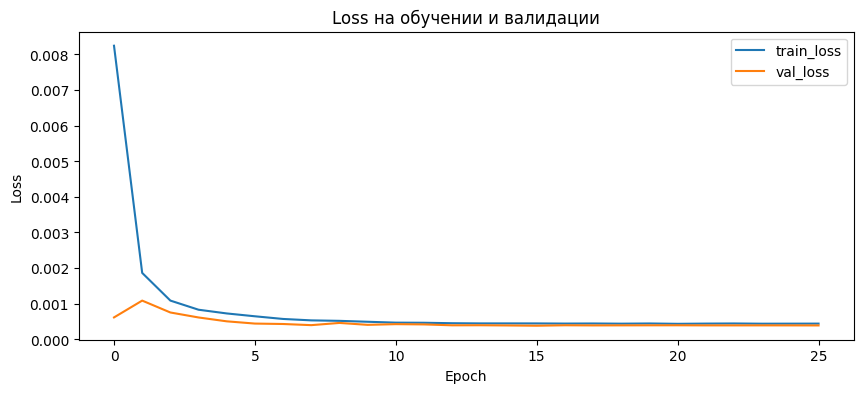

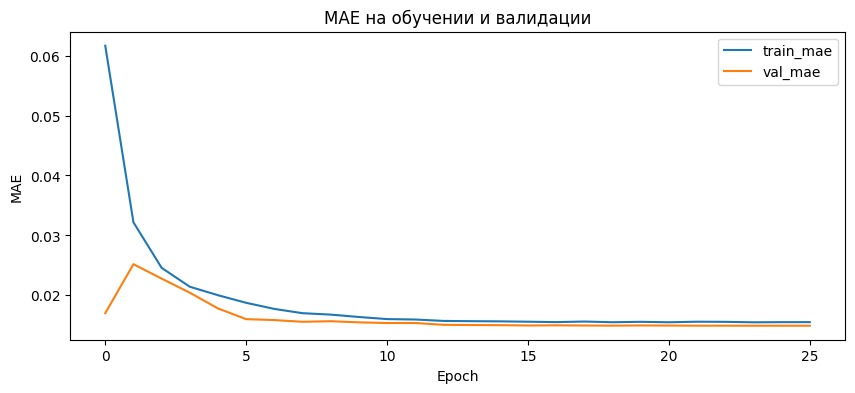

In [466]:
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss на обучении и валидации')
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('MAE на обучении и валидации')
plt.legend()
plt.show()


In [509]:
y_pred_scaled = model3.predict(X_test)


437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [510]:
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_test)

In [511]:
mae = mean_absolute_error(y_true, y_pred)

# RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

MAE: 0.0022
RMSE: 0.0028


#ДЛЯ ПЕРВОЙ МОДЕЛИ:
    MAE: 0.0145
    RMSE: 0.0154

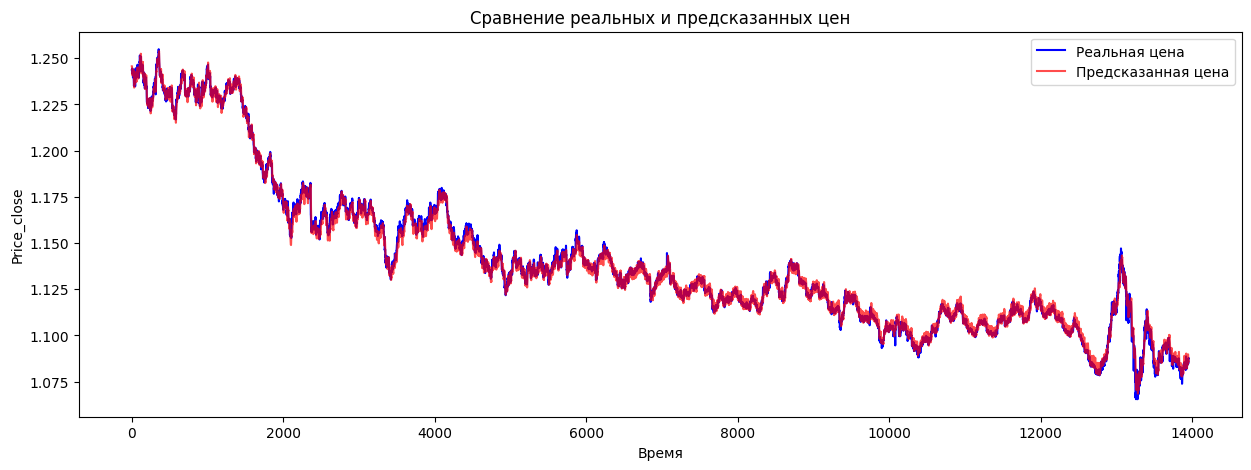

In [512]:
import matplotlib.pyplot as plt

# y_true и y_pred — реальные значения (обратно преобразованные через scaler)
plt.figure(figsize=(15,5))
plt.plot(y_true, label='Реальная цена', color='blue')
plt.plot(y_pred, label='Предсказанная цена', color='red', alpha=0.7)
plt.title('Сравнение реальных и предсказанных цен')
plt.xlabel('Время')
plt.ylabel('Price_close')
plt.legend()
plt.show()


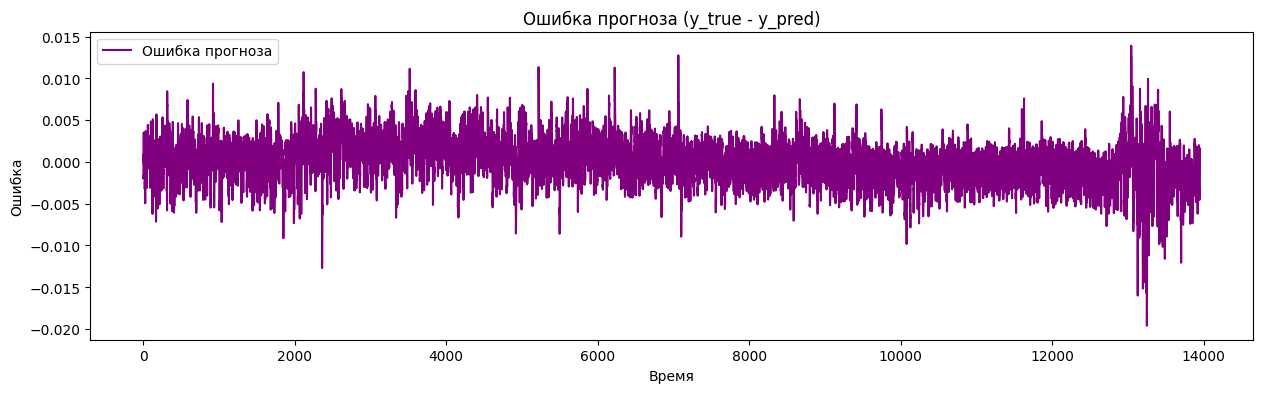

In [513]:
plt.figure(figsize=(15,4))
plt.plot(y_true - y_pred, label='Ошибка прогноза', color='purple')
plt.title('Ошибка прогноза (y_true - y_pred)')
plt.xlabel('Время')
plt.ylabel('Ошибка')
plt.legend()
plt.show()


In [ ]:
model1 = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='Adam', loss='mse', metrics=['mae'])


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32
)

Epoch 1/100


/Users/data/VsCodeProjects/DataScience/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2035/2035 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 1.6724e-05 - mae: 0.0028 - val_loss: 0.0011 - val_mae: 0.0309
Epoch 2/100
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 1.6680e-05 - mae: 0.0028 - val_loss: 0.0012 - val_mae: 0.0317
Epoch 3/100
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 1.6815e-05 - mae: 0.0028 - val_loss: 0.0014 - val_mae: 0.0342
Epoch 4/100
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 1.6352e-05 - mae: 0.0028 - val_loss: 0.0013 - val_mae: 0.0330
Epoch 5/100
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 1.6832e-05 - mae: 0.0028 - val_loss: 0.0013 - val_mae: 0.0326
Epoch 6/100
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 1.6368e-05 - mae: 0.0028 - val_loss: 0.0012 - val_mae: 0.0305
Epoch 7/100
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 1.6581e-05 - mae: 0.0028 - val_loss: 0.0012 - val_mae: 0.0320
Epoch 8/100
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 1.6164e-05 - mae: 0.0028 - val_loss: 0.0014 - val_mae: 0.0335
Epoc